## Exploration

train.csv shape is  (555719, 23)
test.csv shape is  (69465, 2)

       Id trans_date_trans_time        cc_num  \
0  205743      01/09/2020 08:22  5.596350e+15   
1  465349      12/12/2020 07:42  4.311370e+18   
2   17312      27/06/2020 13:03  2.264940e+15   
3  234968      14/09/2020 04:12  2.224100e+15   
4  194255      28/08/2020 17:40  3.527540e+15   

                              merchant       category      amt    first  \
0                      fraud_Berge LLC  gas_transport    72.18   Joseph   
1  fraud_Eichmann, Bogan and Rodriguez  gas_transport    36.66  Phillip   
2              fraud_Ankunding-Carroll         travel     1.74     Juan   
3     fraud_Schumm, Bauch and Ondricka    grocery_pos   140.99    Sheri   
4                    fraud_Gerlach Inc   shopping_net  1722.19   Teresa   

       last gender                        street  ...      lat      long  \
0     Moody      M              5901 Foster Pine  ...  29.9912  -90.2479   
1  Delacruz      M     26678 Lisa Lock

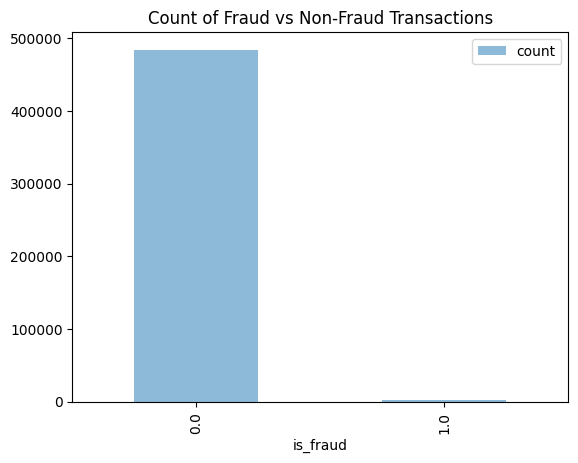

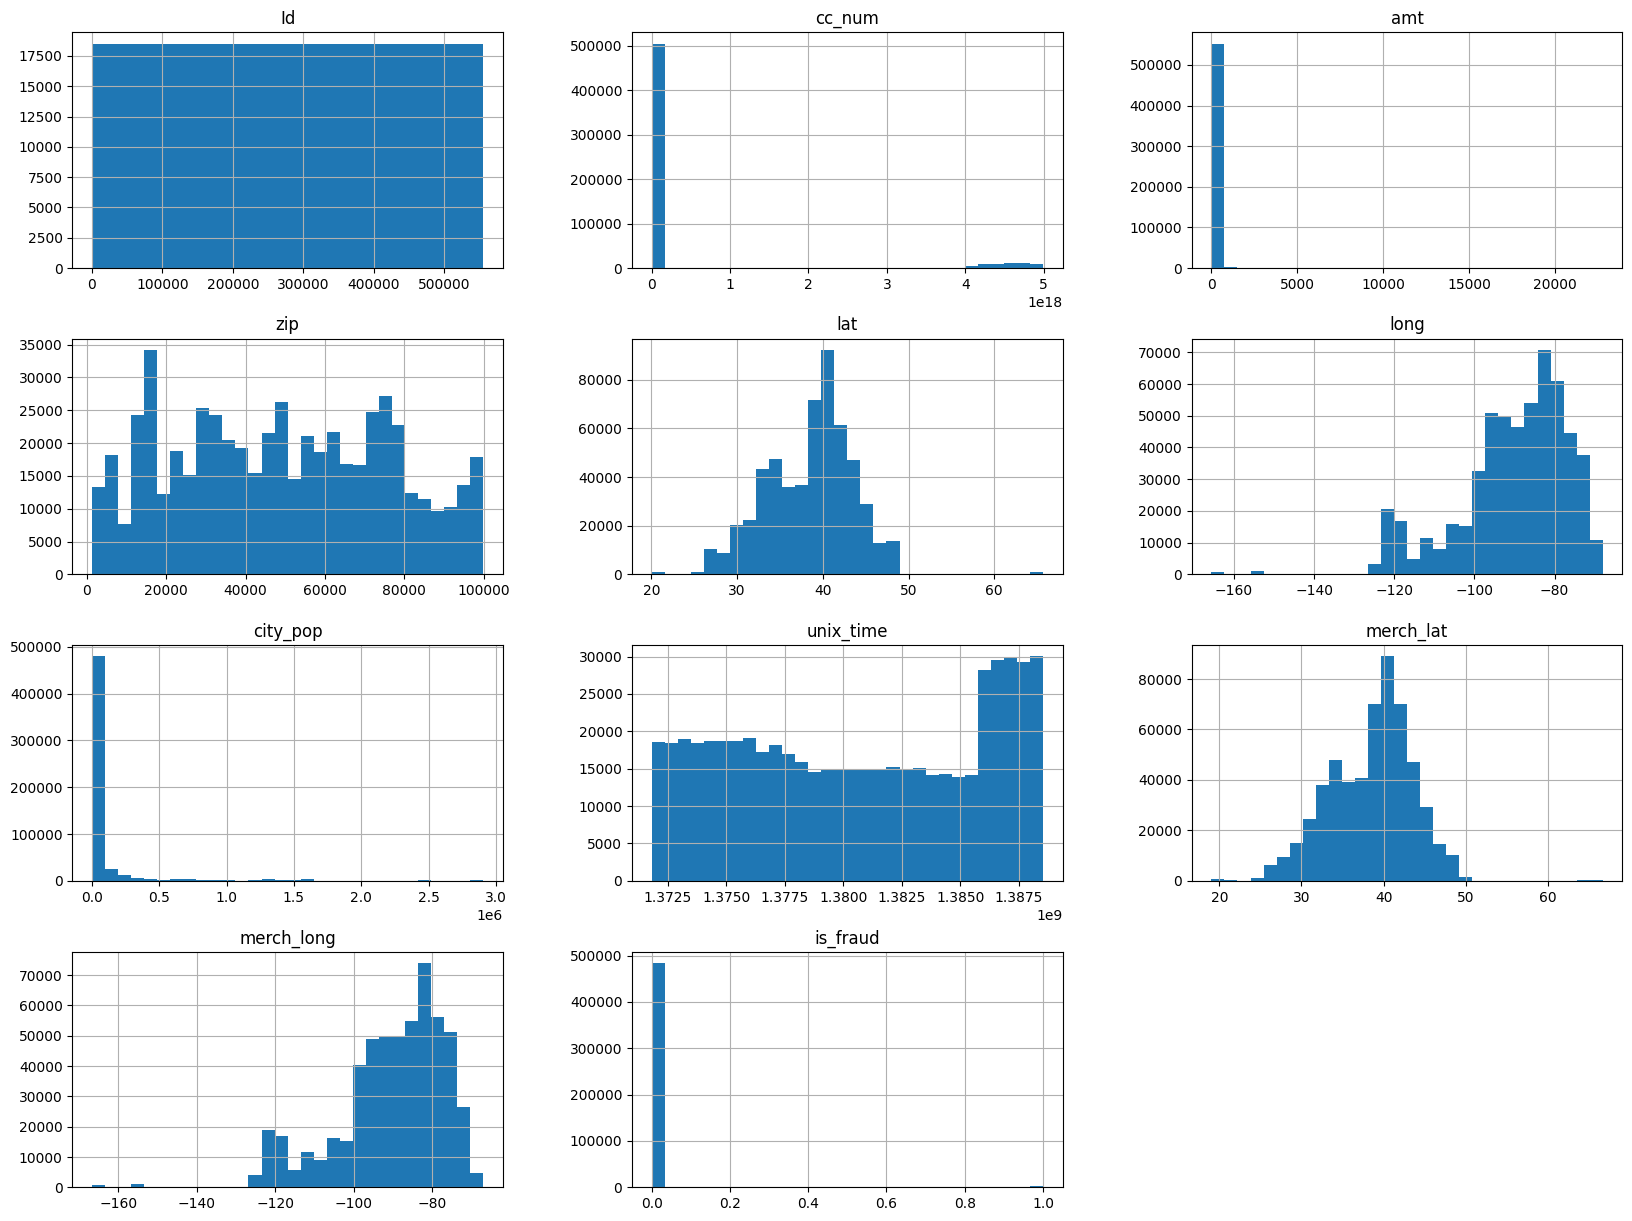

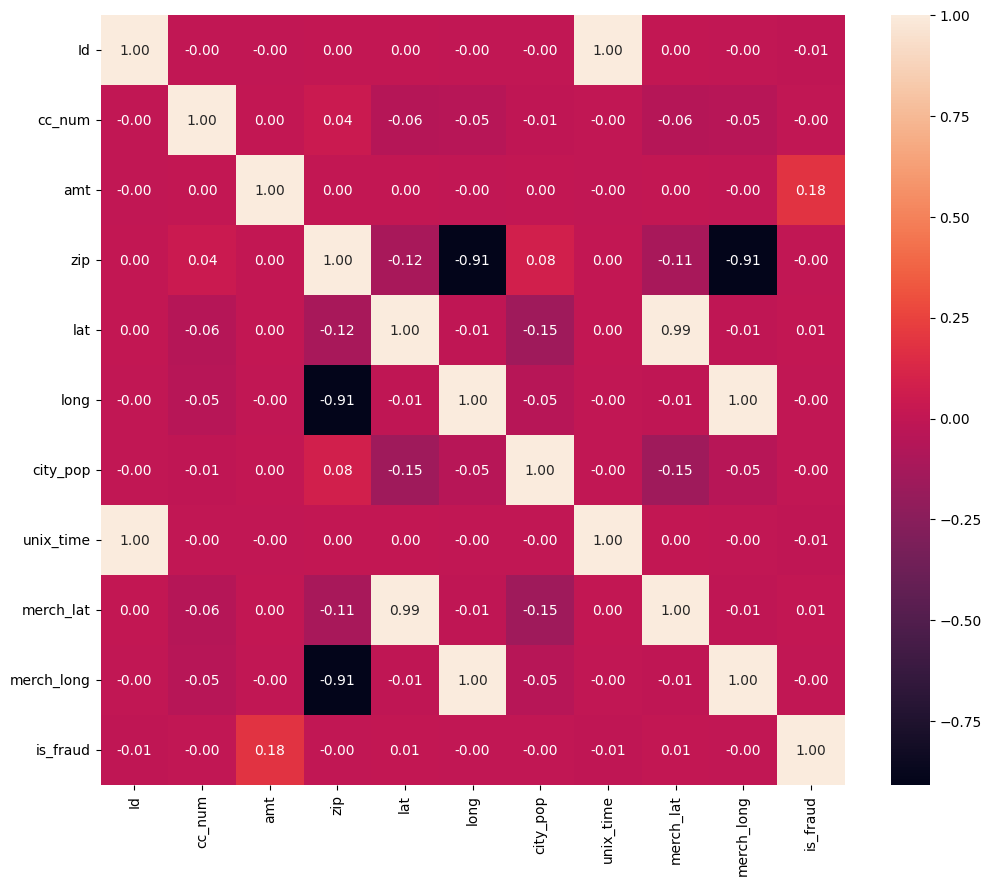

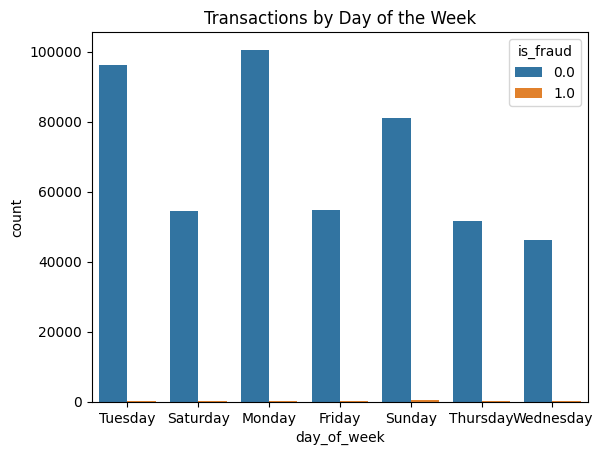

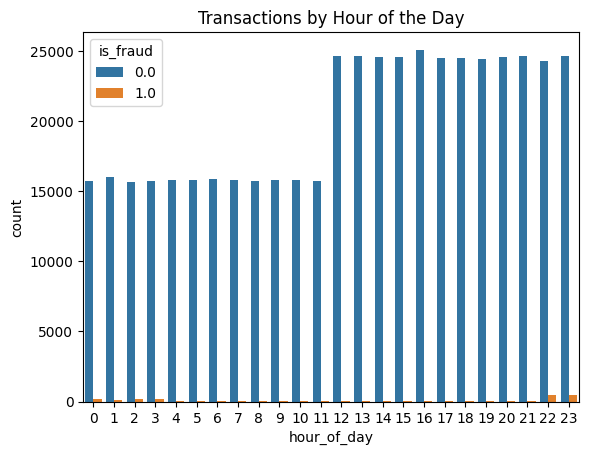

/var/folders/8s/ph8bdmhd7c743w8_56xg70tw0000gn/T/ipykernel_10772/130709952.py:61: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  trainingSet['age'] = today.year - pd.to_datetime(trainingSet['dob']).dt.year


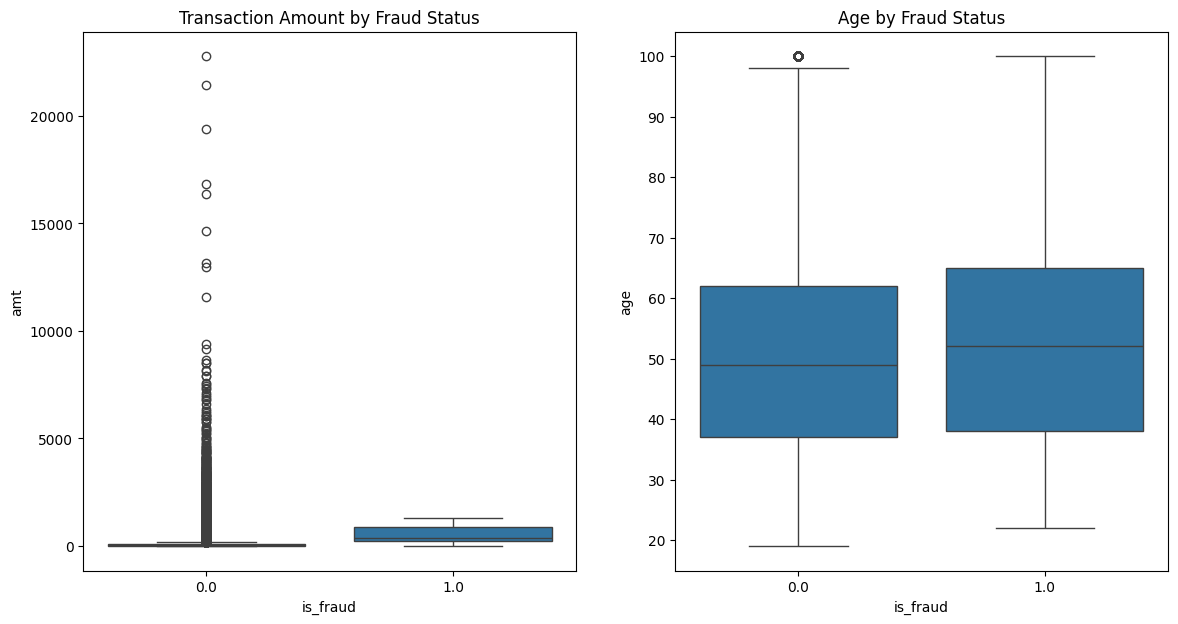

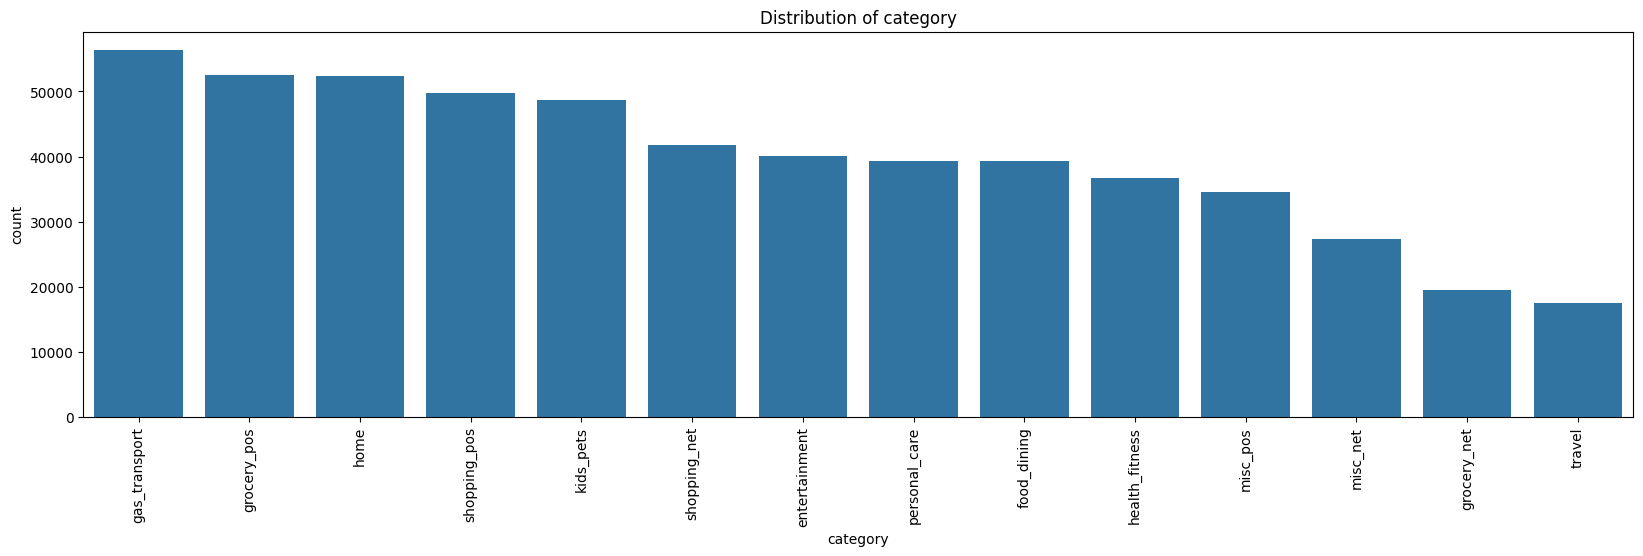

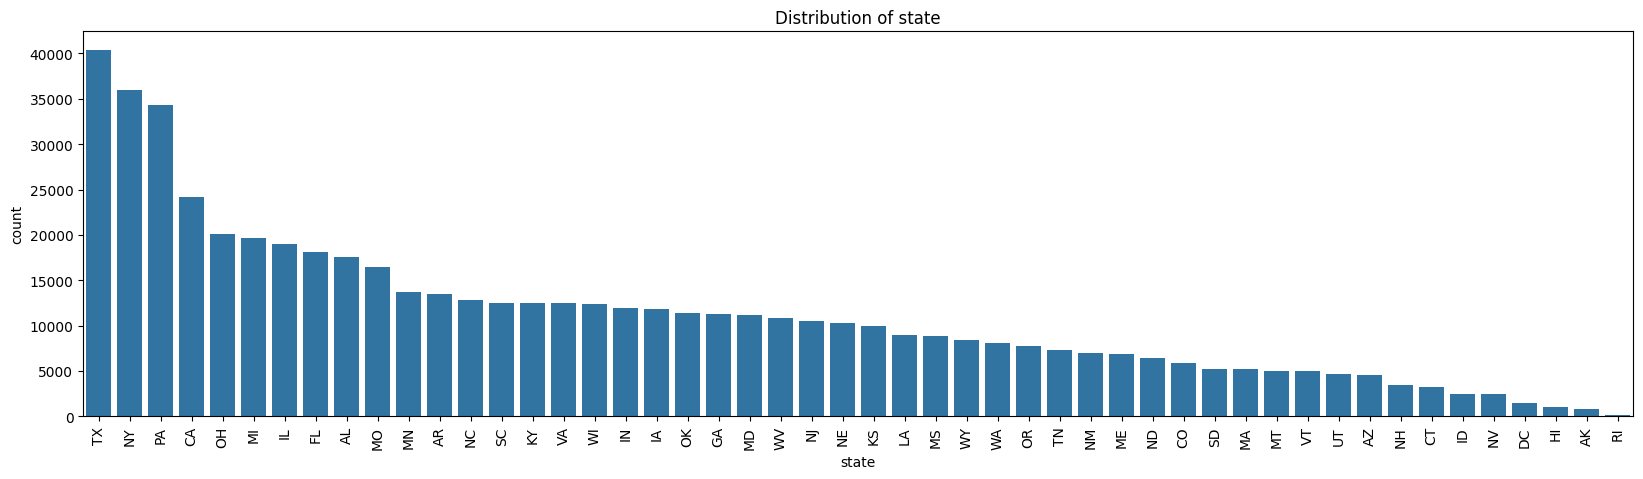

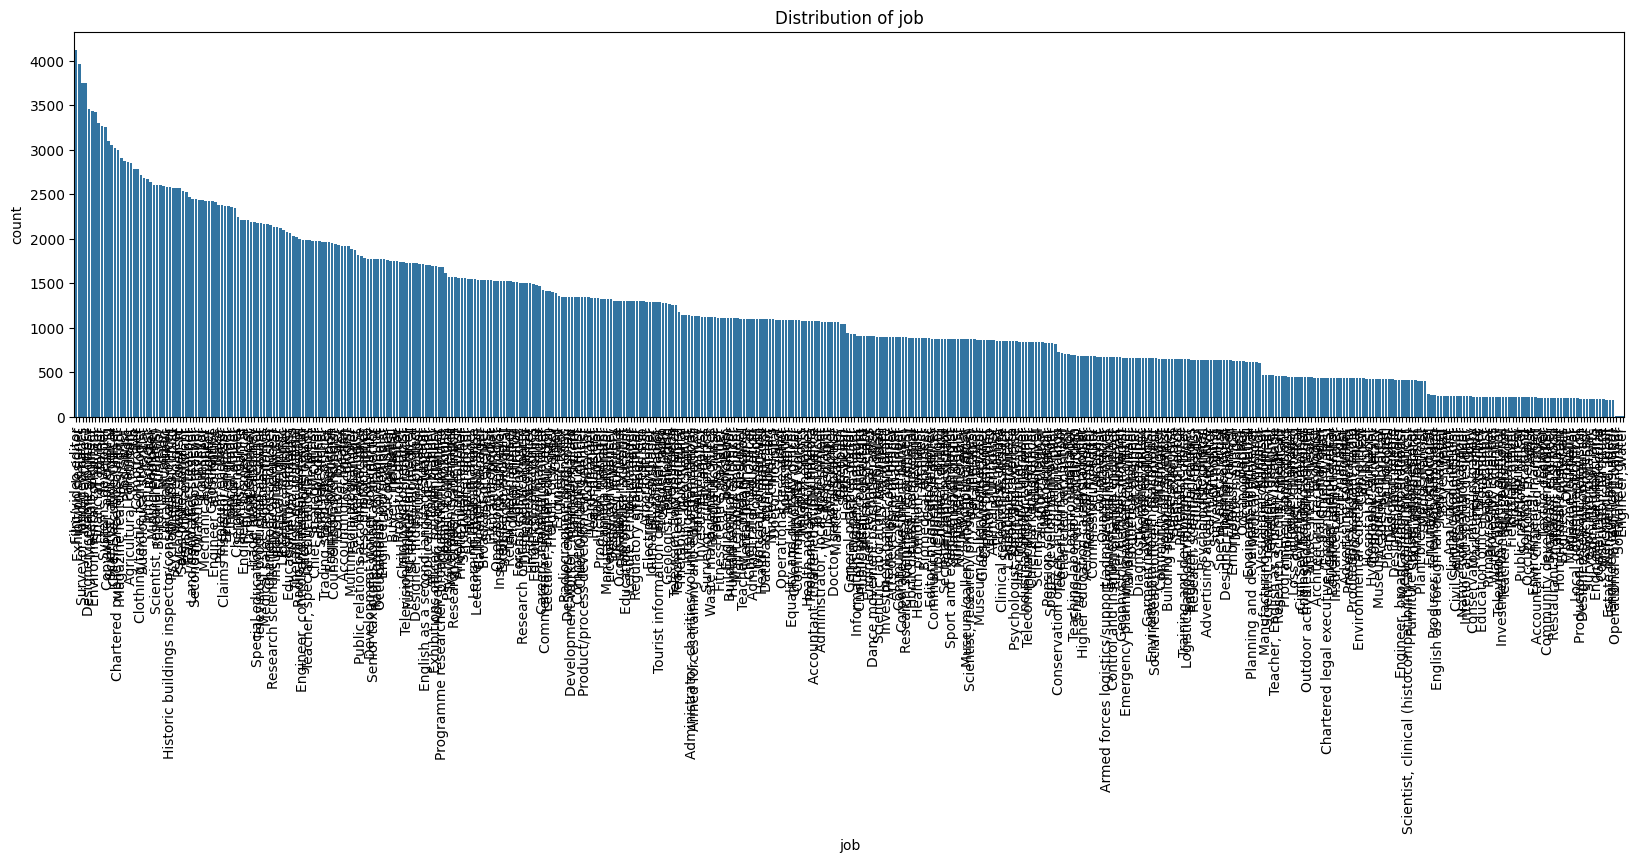

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)
print()
print(trainingSet.head())
print()
print(testingSet.head())
print()

print(trainingSet.describe())

print("Missing values in training set:", trainingSet.isnull().sum())
print("Missing values in testing set:", testingSet.isnull().sum())
print()

trainingSet['is_fraud'].value_counts().plot(kind='bar', legend=True, alpha=0.5)
plt.title("Count of Fraud vs Non-Fraud Transactions")
plt.show()

trainingSet.select_dtypes(include=[np.number]).hist(bins=30, figsize=(20, 15))
plt.show()

numeric_cols = trainingSet.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_cols.corr(), annot=True, fmt=".2f")
plt.show()

trainingSet['trans_date'] = pd.to_datetime(trainingSet['trans_date_trans_time'], format='%d/%m/%Y %H:%M').dt.date
trainingSet['trans_time'] = pd.to_datetime(trainingSet['trans_date_trans_time'], format='%d/%m/%Y %H:%M').dt.time
trainingSet['day_of_week'] = pd.to_datetime(trainingSet['trans_date'], format='%Y-%m-%d').dt.day_name()
trainingSet['hour_of_day'] = pd.to_datetime(trainingSet['trans_date_trans_time'], format='%d/%m/%Y %H:%M').dt.hour

sns.countplot(x='day_of_week', data=trainingSet, hue='is_fraud')
plt.title("Transactions by Day of the Week")
plt.show()

sns.countplot(x='hour_of_day', data=trainingSet, hue='is_fraud')
plt.title("Transactions by Hour of the Day")
plt.show()

today = datetime.today()
trainingSet['age'] = today.year - pd.to_datetime(trainingSet['dob']).dt.year

fig, ax = plt.subplots(1, 2, figsize=(14, 7))
sns.boxplot(x='is_fraud', y='amt', data=trainingSet, ax=ax[0])
ax[0].set_title("Transaction Amount by Fraud Status")
sns.boxplot(x='is_fraud', y='age', data=trainingSet, ax=ax[1])
ax[1].set_title("Age by Fraud Status")
plt.show()

for column in ['category', 'state', 'job']:
    plt.figure(figsize=(20, 5))
    sns.countplot(x=column, data=trainingSet, order = trainingSet[column].value_counts().index)
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=90)
    plt.show()




## Feature Extraction

In [1]:
import pandas as pd

def process(df):
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], format='%d/%m/%Y %H:%M')
    df['trans_date'] = df['trans_date_trans_time'].dt.date
    df['trans_time'] = df['trans_date_trans_time'].dt.time
    
    df.drop(columns=['trans_date_trans_time','trans_date', 'trans_time', 'merchant','category', 'first', 'last', 'gender', 'street', 'city', 'state', 'job', 'trans_num'], inplace=True) 


    return df


trainingSet = pd.read_csv("./data/train.csv")


train_processed = process(trainingSet)


submissionSet = pd.read_csv("./data/test.csv")

testX= pd.merge(train_processed, submissionSet, left_on='Id', right_on='Id')
testX = testX.drop(columns=['is_fraud_x'])
testX = testX.rename(columns={'is_fraud_y': 'is_fraud'})

trainX =  train_processed[train_processed['is_fraud'].notnull()]

testX.to_csv("./data/X_test.csv", index=False)
trainX.to_csv("./data/X_train.csv", index=False)

## Creating your model

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb


train_df1 = pd.read_csv("./data/X_train.csv")
print(train_df1.columns)


def calculate_seconds_since_last_fraud_unix(group):
    group = group.sort_values('unix_time')
    fraud_timestamps = group['unix_time'][group['is_fraud'] == 1]
    seconds_since_last_fraud = group['unix_time'].apply(
        lambda x: (x - fraud_timestamps[fraud_timestamps < x]).min() if not fraud_timestamps[fraud_timestamps < x].empty else 365 * 24 * 3600)
    return seconds_since_last_fraud

train_df1['seconds_since_last_fraud_unix'] = train_df1.groupby('cc_num').apply(calculate_seconds_since_last_fraud_unix).reset_index(level=0, drop=True)


train_df1['seconds_since_last_fraud_unix'] = train_df1.groupby('user_identifier').apply(calculate_seconds_since_last_fraud_unix).reset_index(level=0, drop=True)

df_train = train_df1.dropna(subset=['is_fraud'])

# Feature selection and split the data
specified_columns = ['amt','zip','lat','long', 'merch_lat'] 
X = df_train[specified_columns]
y = df_train['is_fraud']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
param_grid = {
    'n_estimators': [625],
    'learning_rate': [0.29, 0.28, 0.27],
    'max_depth': [5, 6, 7],
    'colsample_bytree': [0.75, 0.65, 0.7],
    'subsample': [1.0]
}


grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)


print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

y_pred_dt = grid_search.best_estimator_.predict(X_val_scaled)
print("XGBC:", f1_score(y_val, y_pred_dt))


cm = confusion_matrix(y_val, y_pred_dt)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix of the Optimized Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Accuracy on testing set: 0.996658132050056
F1 score on testing set: 0.36893203883495146


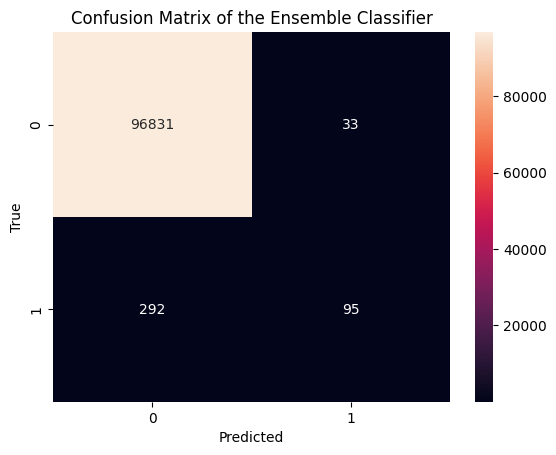

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler

X_train_df = pd.read_csv("./data/X_train.csv")


X, y = X_train_df.drop(['is_fraud'], axis=1), X_train_df['is_fraud']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=40)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=1)
dt = DecisionTreeClassifier(max_depth=10)
lr = LogisticRegression()

voting_clf = VotingClassifier(estimators=[('knn', knn), ('dt', dt), ('lr', lr)], voting='soft')


voting_clf.fit(X_train_scaled, Y_train)

Y_test_predictions = voting_clf.predict(X_test_scaled)
accuracy = accuracy_score(Y_test, Y_test_predictions)
f1 = f1_score(Y_test, Y_test_predictions)

print("Accuracy on testing set:", accuracy)
print("F1 score on testing set:", f1)

cm = confusion_matrix(Y_test, Y_test_predictions)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix of the Ensemble Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1; total time=   4.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1; total time=   4.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1; total time=   4.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   5.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   5.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   5.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   9.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   9.5s
[CV] END colsam

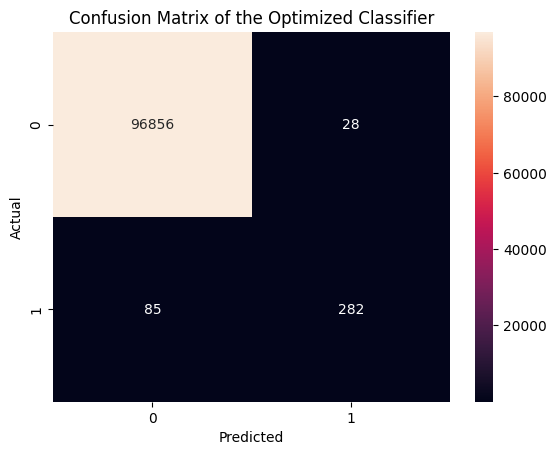

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

X_train_df = pd.read_csv("./data/X_train.csv")

X, y = X_train_df.drop(['is_fraud'], axis=1), X_train_df['is_fraud']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
}

xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, Y_train)

best_model = grid_search.best_estimator_

Y_test_predictions = best_model.predict(X_test_scaled)
accuracy = accuracy_score(Y_test, Y_test_predictions)
f1 = f1_score(Y_test, Y_test_predictions)

print(f"Best model parameters: {grid_search.best_params_}")
print(f"Accuracy on testing set: {accuracy}")
print(f"F1 score on testing set: {f1}")

cm = confusion_matrix(Y_test, Y_test_predictions)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix of the Optimized Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Best parameters found: {'knn__metric': 'manhattan', 'knn__weights': 'uniform'}
Accuracy on testing set: 0.9971825482514318
F1 score on testing set: 0.6682808716707022


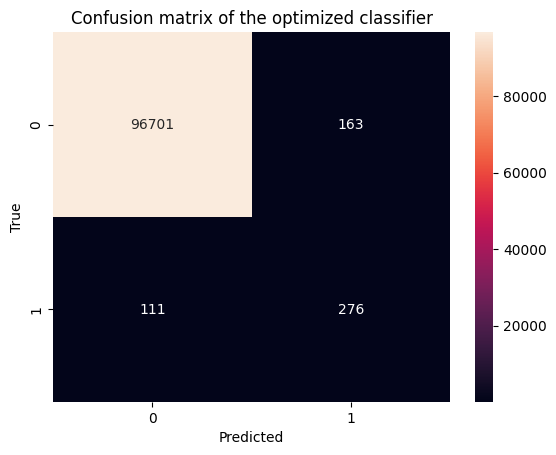

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

X_train = pd.read_csv("./data/X_train.csv")

X, X_test, y, Y_test = train_test_split(
    X_train.drop(['is_fraud'], axis=1),  
    X_train['is_fraud'],  
    test_size=1/5,  
    random_state=40   
)

pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('knn', KNeighborsClassifier(n_neighbors=1))  
])

param_grid = {
    'knn__weights': ['uniform', 'distance'], 
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']  
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)

grid_search.fit(X, y)

print("Best parameters found:", grid_search.best_params_)

best_model = grid_search.best_estimator_
Y_test_predictions = best_model.predict(X_test)

print("Accuracy on testing set:", accuracy_score(Y_test, Y_test_predictions))
print("F1 score on testing set:", f1_score(Y_test, Y_test_predictions))

cm = confusion_matrix(Y_test, Y_test_predictions)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion matrix of the optimized classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Accuracy on testing set =  0.9994036051043177
F1 score on testing set =  0.9260204081632653


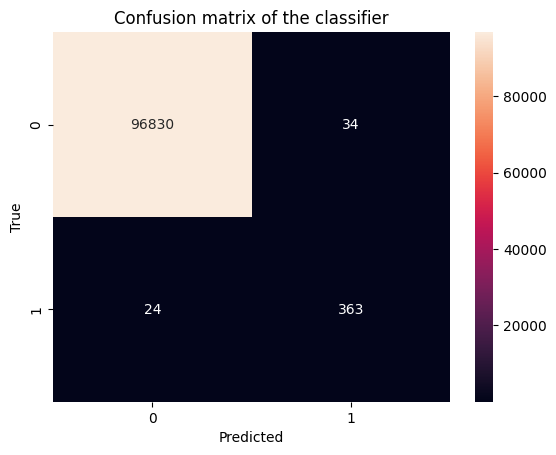

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

X_train = pd.read_csv("./data/X_train.csv")

X_train, X_test, Y_train, Y_test = train_test_split(
        X_train.drop(['is_fraud'], axis=1),  
        X_train['is_fraud'],  
        test_size=1/5,  
        random_state=40   =
)


X_train_processed = X_train._get_numeric_data()  
X_test_processed = X_test._get_numeric_data()    

model = KNeighborsClassifier(n_neighbors=1)  
model.fit(X_train_processed, Y_train)

Y_test_predictions = model.predict(X_test_processed)

print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))
print("F1 score on testing set = ", f1_score(Y_test, Y_test_predictions))

cm = confusion_matrix(Y_test, Y_test_predictions)
sns.heatmap(cm, annot=True, fmt='d')  
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Accuracy on testing set =  0.9976658337703468
F1 score on testing set =  0.588021778584392


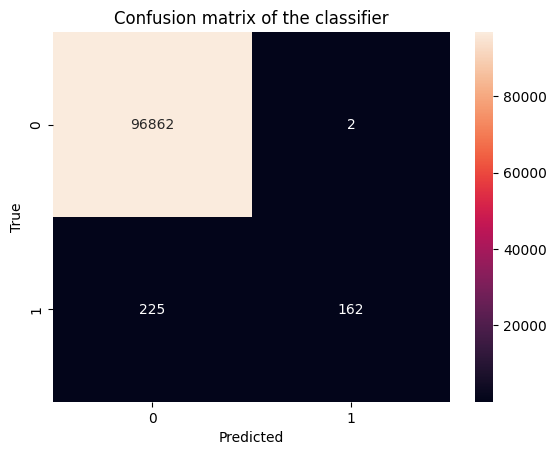

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

X_train_full = pd.read_csv("./data/X_train.csv")

categorical_cols = ['merchant', 'category', 'gender', 'state', 'job']  
numeric_cols = ['amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long']  

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

X = X_train_full.drop(['is_fraud'], axis=1)
y = X_train_full['is_fraud']

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=1/5.0, random_state=40)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', RandomForestClassifier(n_estimators=100, random_state=40))])

pipeline.fit(X_train, Y_train)

Y_test_predictions = pipeline.predict(X_test)

print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))
print("F1 score on testing set = ", f1_score(Y_test, Y_test_predictions))

cm = confusion_matrix(Y_test, Y_test_predictions)
sns.heatmap(cm, annot=True, fmt='d') 
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Average F1 score from cross-validation: 0.5655361703932177
Accuracy on testing set =  0.9965244573320583
F1 score on testing set =  0.5806451612903226


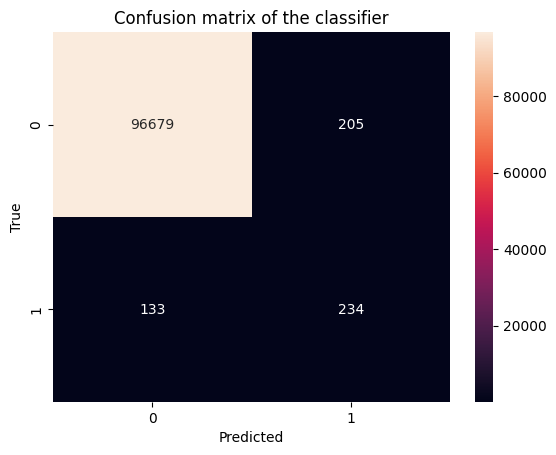

In [98]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler

X_train_full = pd.read_csv("./data/X_train.csv")

X = X_train_full.drop(['is_fraud'], axis=1)._get_numeric_data() 
y = X_train_full['is_fraud']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = KNeighborsClassifier(n_neighbors=1)  

f1_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='f1') 
print("Average F1 score from cross-validation:", f1_scores.mean())

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, y, test_size=1/5.0, random_state=0)

model.fit(X_train, Y_train)

Y_test_predictions = model.predict(X_test)

print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))
print("F1 score on testing set = ", f1_score(Y_test, Y_test_predictions))

cm = confusion_matrix(Y_test, Y_test_predictions)
sns.heatmap(cm, annot=True, fmt='d')  
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Accuracy on testing set =  0.9994036051043177
F1 score on testing set =  0.9260204081632653


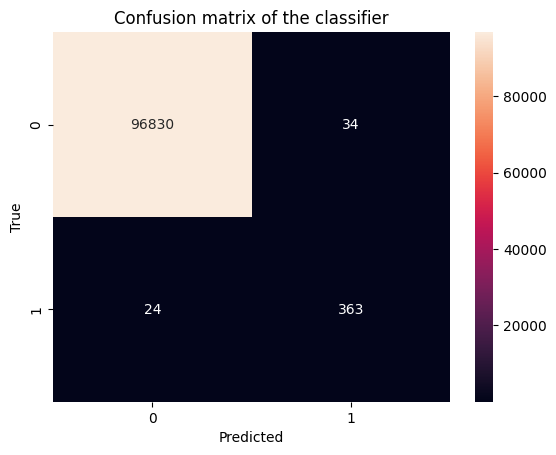

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

X_train = pd.read_csv("./data/X_train.csv")

X_train, X_test, Y_train, Y_test = train_test_split(
        X_train.drop(['is_fraud'], axis=1),  
        X_train['is_fraud'], 
        test_size=1/5,  
        random_state=40   
)

X_train_processed = X_train._get_numeric_data()  
X_test_processed = X_test._get_numeric_data()   

model = KNeighborsClassifier(n_neighbors=1)  
model.fit(X_train_processed, Y_train)

Y_test_predictions = model.predict(X_test_processed)

print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))
print("F1 score on testing set = ", f1_score(Y_test, Y_test_predictions))

cm = confusion_matrix(Y_test, Y_test_predictions)
sns.heatmap(cm, annot=True, fmt='d')  
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


## Create the Kaggle submission

In [18]:
X_submission = pd.read_csv("./data/X_test.csv")
X_submission_processed = X_submission._get_numeric_data().drop(columns=['is_fraud'])
print(X_submission_processed.columns)

X_submission['is_fraud'] = model.predict(X_submission_processed)
X_submission.is_fraud = X_submission.is_fraud.astype(int)
submission = X_submission[['Id', 'is_fraud']]
submission.to_csv("./data/submission.csv", index=False)

Index(['Id', 'cc_num', 'amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time',
       'merch_lat', 'merch_long'],
      dtype='object')


Now you can upload the `submission.csv` to kaggle